# Exploratory Data Analysis

## 1. ECG Beat Classification

In this part, we are going to analyse data loaded from different datasets such as MIT-BIH, MIT-BIH-Atrial-Fibrillation, INCART, European-st in order to classify properly ECG signals to 5 different classes (N: Normal, S: Superventricular, V: Ventricular, F: Fusion, Q: Unkown)

#### Why do we need this exploratory data analysis
- Understand data before modeling anything
- what does data look like?
- Is it clean?
- Is it balanced?
- Are there anomalies, noise, or missing values

In [209]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import wfdb


### 1.1 Data inspection

#### a) <u>Shape of data</u>

In [210]:
# Auto-detect project root (folder containing "data")
def get_project_root():
    path = os.getcwd()
    while True:
        if "data" in os.listdir(path):
            return path
        parent = os.path.dirname(path)
        if parent == path:
            raise RuntimeError("Could not find project root")
        path = parent

PROJECT_ROOT = get_project_root()
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "raw")

print("Project root:", PROJECT_ROOT)
print("Data root:", DATA_ROOT)


Project root: c:\Users\HP\Desktop\ecg_project
Data root: c:\Users\HP\Desktop\ecg_project\data\raw


In [211]:
# Define project root
PROJECT_ROOT = os.path.dirname(os.getcwd())  # Goes from notebooks/ to project root

# Load data using project root
X_path = os.path.join(PROJECT_ROOT, "data", "processed", "beat_X.npy")
y_path = os.path.join(PROJECT_ROOT, "data", "processed", "beat_y.npy")

print(f"Loading X from: {X_path}")
print(f"Loading y from: {y_path}")

X = np.load(X_path)
y = np.load(y_path)

Loading X from: c:\Users\HP\Desktop\ecg_project\data\processed\beat_X.npy
Loading y from: c:\Users\HP\Desktop\ecg_project\data\processed\beat_y.npy


In [212]:
print(X.shape)
print(y.shape)

(1084298, 180, 1)
(1084298,)


In [213]:
# print Data Types
print(f"X dtype: {X.dtype}")
print(f"y dtype: {y.dtype}")

print("\nMemory usage:")
print(f"X: {X.nbytes:,} bytes ({X.nbytes/1024**2:.1f} MB)")
print(f"y: {y.nbytes:,} bytes ({y.nbytes/1024**2:.1f} MB)")
print(f"Total: {(X.nbytes + y.nbytes)/1024**2:.1f} MB")

X dtype: float64
y dtype: int32

Memory usage:
X: 1,561,389,120 bytes (1489.1 MB)
y: 4,337,192 bytes (4.1 MB)
Total: 1493.2 MB


In [214]:
print("\n ECG Beats with Class Names:")

class_names = {
    0: 'N - Normal',
    1: 'S - Supraventricular',
    2: 'V - Ventricular',
    3: 'F - Fusion',
    4: 'Q - Unknown'
}

data_with_names = []
for i in range(5):
    cls = int(y[i])
    class_name = class_names.get(cls, f'Class {cls}')
    

    signal = X[i, :, 0]
    peak_to_peak = signal.max() - signal.min()
    
    data_with_names.append({
        'Sample': f'Beat_{i+1:03d}',
        'Class_ID': cls,
        'Class_Name': class_name,
        'Amplitude_Range': f"{peak_to_peak:.3f} mV",
        'Duration': f"{len(signal)} samples",
        'Mean_Value': f"{signal.mean():.4f}"
    })

df_beats = pd.DataFrame(data_with_names)
display(df_beats.style
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center')]},
        {'selector': 'thead th', 'props': [('background-color', "#f0f0f000"), 
                                          ('font-weight', 'bold')]}
    ]))


 ECG Beats with Class Names:


,Sample,Class_ID,Class_Name,Amplitude_Range,Duration,Mean_Value
0,Beat_001,0,N - Normal,1.962 mV,180 samples,0.5964
1,Beat_002,0,N - Normal,1.971 mV,180 samples,0.6229
2,Beat_003,0,N - Normal,2.034 mV,180 samples,0.6175
3,Beat_004,0,N - Normal,2.028 mV,180 samples,0.5929
4,Beat_005,0,N - Normal,1.889 mV,180 samples,0.5989


In [215]:
# Check signal range
min_val_x, max_val_x = X.min(), X.max()

print(f"Signal range: [{min_val_x:.3f}, {max_val_x:.3f}]")


Signal range: [-15.091, 15.047]


#### b) <u>Sample/Class counts</u>

In [216]:
X = np.load("../data/processed/beat_X.npy")  # Shape: (1084298, 180, 1)
y = np.load("../data/processed/beat_y.npy")  # Shape: (1084298,)

print("DATASET OVERVIEW") 
print()
print(f"Total samples (beats): {X.shape[0]:,}")
print(f"Time points per beat: {X.shape[1]}")
print(f"Signal duration: {X.shape[1]/360:.2f} seconds (36 Hz)")
print(f"Number of features: {X.shape[2]} (Single lead)")
print(f"Number of classes: {len(np.unique(y))}")

DATASET OVERVIEW

Total samples (beats): 1,084,298
Time points per beat: 180
Signal duration: 0.50 seconds (36 Hz)
Number of features: 1 (Single lead)
Number of classes: 5


### 1.2 Visualization

#### a) <u>Distribution</u>

##### Signal Amplitude Distribution

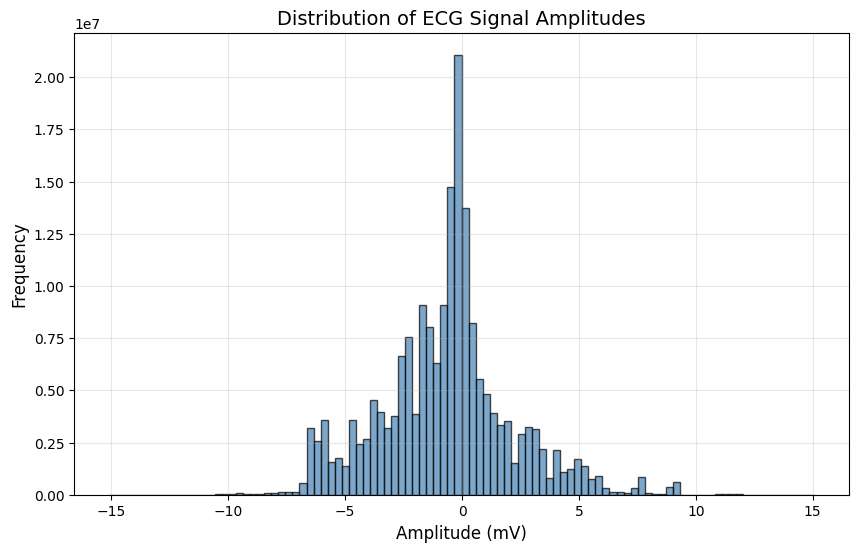

In [217]:
# Flatten all ECG signals
all_signals = X.flatten()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(all_signals, bins=100, alpha=0.7, color='steelblue', edgecolor='black')
plt.title("Distribution of ECG Signal Amplitudes", fontsize=14)
plt.xlabel("Amplitude (mV)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(alpha=0.3)
plt.show()

- From this distribution we can say that our signal amplitude is in normal range (-5mV to +5mV)

##### Class Label Distribution

<BarContainer object of 5 artists>

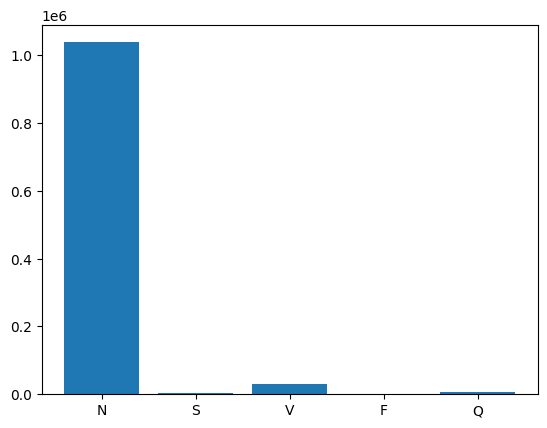

In [218]:
# How many samples per heartbeat class
unique, counts = np.unique(y, return_counts=True)
plt.bar(['N', 'S', 'V', 'F', 'Q'], counts)

- We can clearly see that our dataset is completely imbalanced we can get 90% just by predecting the normal class and that's not correct.

##### ECG Plot

In [219]:
def load_ecg(record_path, lead=0):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, lead]
    fs = record.fs
    return signal, fs

def plot_ecg(signal, fs, start_sec=0, duration_sec=10, title="Raw ECG"):
    start_sample = int(start_sec * fs)
    end_sample = int((start_sec + duration_sec) * fs)

    segment = signal[start_sample:end_sample]
    t = np.arange(len(segment)) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, segment)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.grid(True)
    plt.show()

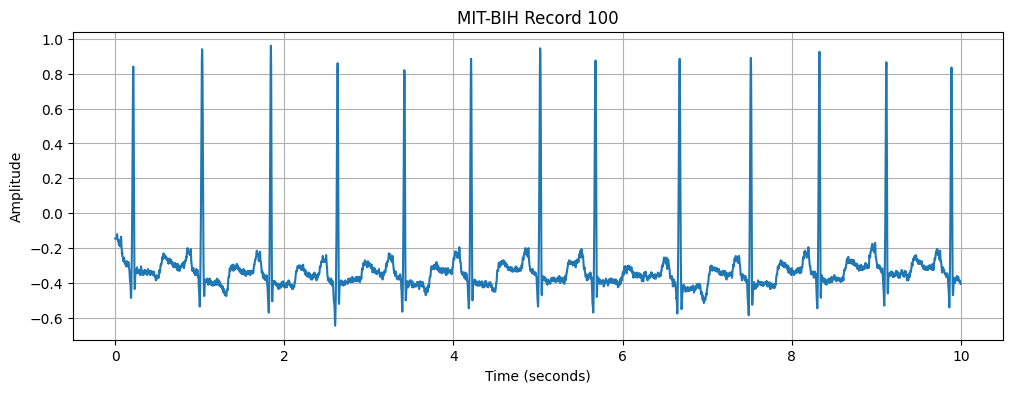

In [220]:
DATA_ROOT = os.path.join(PROJECT_ROOT, "data", "raw")
record_path = os.path.join(DATA_ROOT, "mitdb", "100")
signal, fs = load_ecg(record_path)
plot_ecg(signal, fs, duration_sec=10, title="MIT-BIH Record 100")

##### ECG Plot with R-Peaks

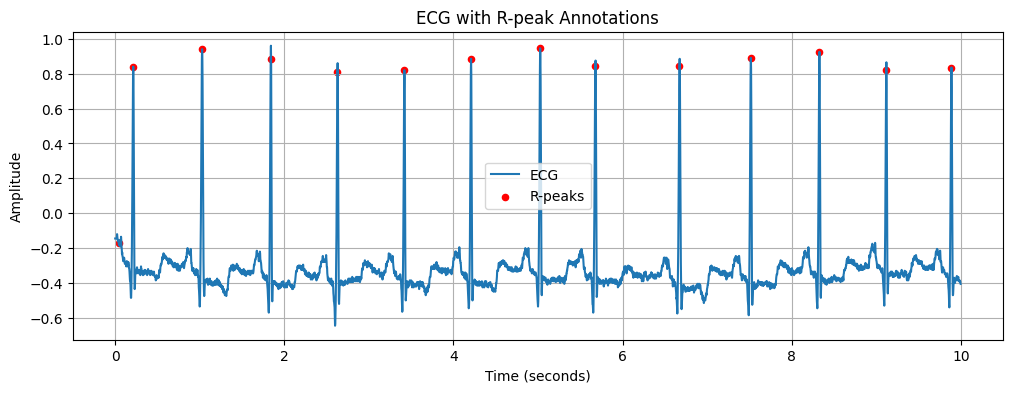

In [221]:
def plot_ecg_with_rpeaks(record_path, lead=0, start_sec=0, duration_sec=10):
    record = wfdb.rdrecord(record_path)
    ann = wfdb.rdann(record_path, "atr")

    signal = record.p_signal[:, lead]
    fs = record.fs
    r_peaks = ann.sample

    start_sample = int(start_sec * fs)
    end_sample = int((start_sec + duration_sec) * fs)

    mask = (r_peaks >= start_sample) & (r_peaks <= end_sample)

    t = np.arange(start_sample, end_sample) / fs

    plt.figure(figsize=(12, 4))
    plt.plot(t, signal[start_sample:end_sample], label="ECG")
    plt.scatter(r_peaks[mask] / fs,
                signal[r_peaks[mask]],
                color="red", s=20, label="R-peaks")

    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.title("ECG with R-peak Annotations")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_ecg_with_rpeaks(
    record_path=record_path,
    lead=0,
    start_sec=0,
    duration_sec=10
)
